# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

11720


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v0\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v0\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v0\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [36]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [37]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}

# 2. Load codebook

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load Chr2Zxys dict and contactDict


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [8]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MOp_WT_postanalysis\postanalysis_vCW2_sorted'
subclass_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [9]:
subclass_2_chr2ZxysList.keys()

dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

In [9]:
# subclass to median distance dict
subclass_2_contact_filename = os.path.join(postanalysis_folder, 'subclass_2_contactDict.pkl')
if os.path.exists(subclass_2_contact_filename):
    print("Loading contact")
    subclass_2_contactDict = pickle.load(open(subclass_2_contact_filename, 'rb'))
    
subclass_2_contactDict.keys()

Loading contact


dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

In [10]:
# subclass info
subclass_2_cellInfoList_filename = os.path.join(postanalysis_folder, 'subclass_2_cellInfo.pkl')
subclass_2_cellInfoList = pickle.load(open(subclass_2_cellInfoList_filename, 'rb'))

# 3. Calculate number of contacts for each pair

## genomic distance matrix

In [11]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')

df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
#df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1977,X:166247682-166259932,1059,X,60,CTP11,combo,chrX_166247682_166259932,166247682,166259932,60,159996393,1978
1978,X:167157164-167167452,990,X,61,CTP13,combo,chrX_167157164_167167452,167157164,167167452,61,160905875,1979
1979,X:168746045-168757590,1060,X,62,CTP11,combo,chrX_168746045_168757590,168746045,168757590,62,162494756,1980
1980,X:169963295-170005197,991,X,63,CTP13,combo,chrX_169963295_170005197,169963295,170005197,63,163712006,1981


In [13]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  
import loci_3d_features
importlib.reload(loci_3d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [14]:
# Get ref gene dist mtx
gene_dist_mtx_dict={}

for _chr in np.unique(df_refgen['chr']):
    gene_dist_mtx_dict[_chr]=loci_3d_features.get_genomic_distance_mtx(df_refgen, _chr)

## summarize by genomic distance from single cell data

In [18]:
# define bins for grouping contacts
gene_dist_bins = [(0,2000000), 
                  (2000000,5000000), 
                  (5000000, 10000000),
                  (10000000,20000000),
                  (20000000,50000000),
                  (50000000,200000000)]

# Test for a couple of cells from the Sst cells lis
_contact_count_list = loci_3d_features.Chr2Zxys_list_2_cis_contact_summary(subclass_2_chr2ZxysList['Sst'][0:2], 
                                                     df_refgen, 
                                                     gene_dist_bins, 
                                                     gene_dist_mtx_dict=gene_dist_mtx_dict, 
                                                     contact_th =0.6)

_contact_count_list

[{'1': {(0, 2000000): 58,
   (2000000, 5000000): 54,
   (5000000, 10000000): 56,
   (10000000, 20000000): 44,
   (20000000, 50000000): 54,
   (50000000, 200000000): 74,
   'total': 646},
  '10': {(0, 2000000): 148,
   (2000000, 5000000): 92,
   (5000000, 10000000): 28,
   (10000000, 20000000): 14,
   (20000000, 50000000): 92,
   (50000000, 200000000): 82,
   'total': 690},
  '11': {(0, 2000000): 56,
   (2000000, 5000000): 38,
   (5000000, 10000000): 24,
   (10000000, 20000000): 16,
   (20000000, 50000000): 32,
   (50000000, 200000000): 6,
   'total': 384},
  '12': {(0, 2000000): 38,
   (2000000, 5000000): 20,
   (5000000, 10000000): 0,
   (10000000, 20000000): 0,
   (20000000, 50000000): 26,
   (50000000, 200000000): 16,
   'total': 256},
  '13': {(0, 2000000): 60,
   (2000000, 5000000): 38,
   (5000000, 10000000): 10,
   (10000000, 20000000): 8,
   (20000000, 50000000): 20,
   (50000000, 200000000): 44,
   'total': 364},
  '14': {(0, 2000000): 46,
   (2000000, 5000000): 34,
   (500000

In [19]:
# the th used by Cosmos for compartment and contact
contact_th =0.75

# Multiprcessing all cell types
contact_summary_dict = loci_3d_features.Chr2Zxys_list_2_cis_contact_summary_batch_byclass (subclass_2_chr2ZxysList, 
                                                                          df_refgen, 
                                                                          gene_dist_bins, 
                                                                          gene_dist_mtx_dict=gene_dist_mtx_dict, 
                                                                          contact_th =contact_th, 
                                                                          num_threads = 32)

-- summarize chromosomal contacts for 21 cell types with 32 threads in 45.568s.


## save

In [20]:
import pickle
pickle.dump(contact_summary_dict,open(os.path.join(output_analysis_folder,'cis_contact_singlecell_frequency_subclass.pkl'),'wb'))

## plot

In [21]:
import pickle
contact_summary_dict = pickle.load(open(os.path.join(output_analysis_folder,'cis_contact_singlecell_frequency_subclass.pkl'),'rb'))

In [28]:
contact_summary_dict['Astro'][0]['1'].keys()

dict_keys([(0, 2000000), (2000000, 5000000), (5000000, 10000000), (10000000, 20000000), (20000000, 50000000), (50000000, 200000000), 'total'])

In [29]:
import tqdm
gene_dist_bins = [(0,2000000), 
                  (2000000,5000000), 
                  (5000000, 10000000),
                  (10000000,20000000),
                  (20000000,50000000),
                  (50000000,200000000)]

res_dict = {k:{} for k in gene_dist_bins}


contact_num_th = 1000

for _class, _summary_list in tqdm.tqdm(contact_summary_dict.items()):
    
    for _k, _v in res_dict.items():
        _v[_class] = []

for _class, _summary_list in tqdm.tqdm(contact_summary_dict.items()):
    for _bin_query in res_dict.keys():
        for _contact_summary in _summary_list:
            contact_query = 0
            contact_total = 0
            for _chr, _contact_bybin in _contact_summary.items():
                contact_query += _contact_bybin[_bin_query]
                contact_total += _contact_bybin['total']
                
            contact_query_ratio = contact_query/contact_total
            # set a th for clean cell
            if contact_total >= contact_num_th:
                res_dict[_bin_query][_class].append(contact_query_ratio)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.57it/s]


In [30]:
_contact_result_df_list = []
_contact_result_df_dict = {}
for _bin_query, _contact_result in res_dict.items():
    _contact_result_df = pd.DataFrame.from_dict(res_dict[_bin_query], orient='index').transpose()
    _contact_result_df_list.append(_contact_result_df)
    _contact_result_df_dict[_bin_query] = _contact_result_df

In [42]:
sel_sorted_bin_keys = [(20000000,50000000),(10000000, 20000000),(2000000,5000000), (0, 2000000)]
sorted_cell_labels = ['Micro', 'SMC', 'Peri', 'Oligo', 'Endo', 'VLMC', 'Astro', 'L6 CT',
       'L4/5 IT', 'OPC', 'L6 IT', 'L6b', 'L5/6 NP', 'Lamp5', 'L2/3 IT', 'Sst',
       'L5 IT', 'Vip', 'Sncg', 'Pvalb', 'L5 ET']


res_dict_df_list= []
for _bin_key in sel_sorted_bin_keys:
    res_dict_df_list.append(_contact_result_df_dict[_bin_key])

res_dict_df=pd.concat(res_dict_df_list)
cell_type_medians = np.nanmedian(res_dict_df, axis=0)
#sorted_cell_labesl = res_dict_df.columns[np.argsort(cell_type_medians)]
res_dict_df = res_dict_df[sorted_cell_labels[::-1]]
res_dict_df = res_dict_df*100

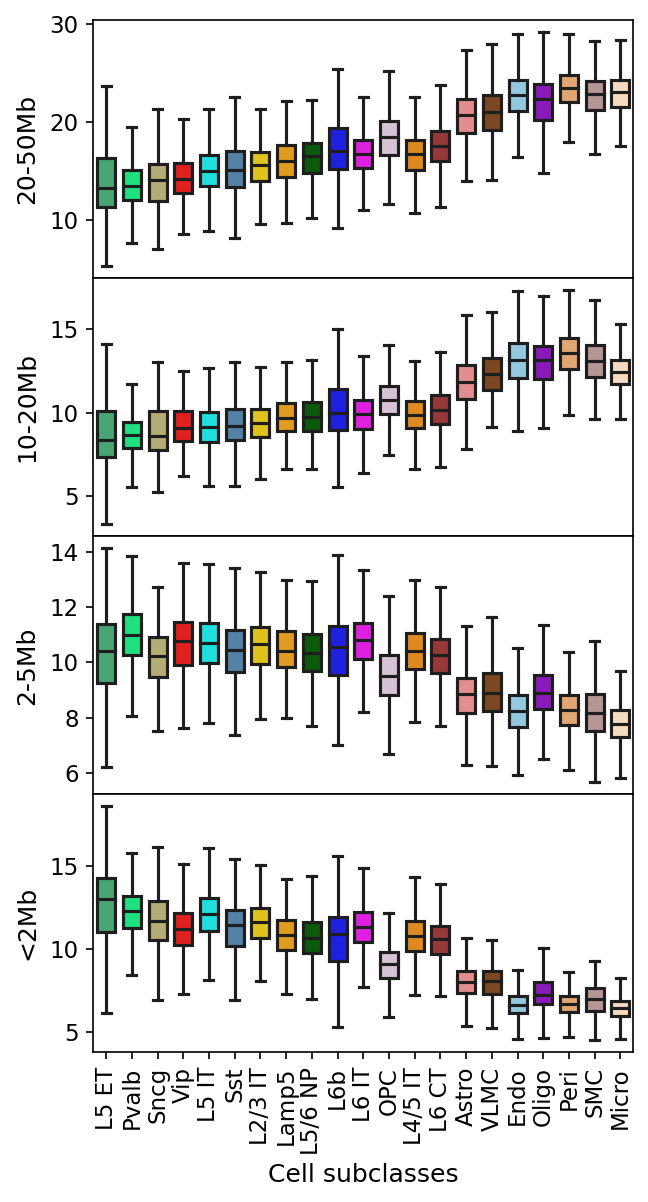

In [51]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.dpi'] = 300

plt.style.use('default')
#plt.style.use('dark_background')

fig, axes = plt.subplots(len(sel_sorted_bin_keys),1, 
                         figsize=(4,8), 
                         sharex=True, sharey=False, dpi=150)



ylabel_list = ['20-50Mb', '10-20Mb','2-5Mb','<2Mb']
#ylim_list = [[0.2,3],[0.3,3.5],[0.3,3.5],[0,1.55],]
ylim_list = [[],[],[],[],]
#cell_type_medians = np.nanmedian(res_dict_df, axis=0)
#sorted_cell_labels = res_dict_df.columns[np.argsort(cell_type_medians)]


for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
    res_dict_df = _contact_result_df_dict[_bin_key]
    cell_type_medians = np.nanmedian(res_dict_df, axis=0)
    
    # get label order from the first bin
    #if _idx == 0:
        #sorted_cell_labesl = res_dict_df.columns[np.argsort(cell_type_medians)]
        
    res_dict_df = res_dict_df[sorted_cell_labels[::-1]]
    res_dict_df = res_dict_df*100
    sns.boxplot(res_dict_df, showfliers=False, ax=axes[_idx],palette=celltype_palette,width=0.7)
    axes[_idx].tick_params(labelleft=False)

        
for _ax_idx, _ax in enumerate(axes):
    _ax.set_ylabel(ylabel_list[_ax_idx], rotation=90, fontsize=12,labelpad=5)
    _ax.tick_params(axis='y', labelsize=11,labelleft=True)
    if _ax_idx!=len(axes)-1:
        _ax.tick_params(labelbottom=False)
        _ax.set_xlabel("", rotation=0, fontsize=12)
        _ax.tick_params(axis='x', rotation=90, labelsize=0,length=0) 
    else:
        _ax.set_xlabel("Cell subclasses", rotation=0, fontsize=12)
        _ax.tick_params(axis='x', rotation=90, labelsize=11) 
    if len(ylim_list[_ax_idx])==2:
        _ax.set_ylim(ylim_list[_ax_idx])
    _ax.grid(False)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
#plt.savefig(os.path.join(output_figure_folder, f'Cis_chrom_pairwise_contact_frequency_singlecell.pdf'), 
            #transparent=True, dpi=300, bbox_inches='tight')

plt.show()